In [1]:
from firedrake import *
import matplotlib.pyplot as plt

# Raymond effect using the PointsolveOperator

## Setup

#### Geometry 

In [2]:
# Geometry
Lx = 3
Ly = 1
nx = 50
ny = 50
mesh = RectangleMesh(nx, ny, Lx, Ly)
x, y = SpatialCoordinate(mesh)

#### Function spaces

In [3]:
# Function spaces
V1 = VectorFunctionSpace(mesh, "CG", 2) # velocity
V2 = FunctionSpace(mesh, "CG", 1) # pressure
V3 = TensorFunctionSpace(mesh, "DG", 2) # stress tensor
W = MixedFunctionSpace((V1, V2))

In [4]:
w, phi = TestFunctions(W)
sol = Function(W)
u, p = split(sol)

#### Paramaters

In [5]:
# Parameters
ng = 3  # Exponent in the Glen's law
b = Constant(0.1)
rho = Constant(0.9)
g = Constant(9.81)
f = Function(V1).interpolate(as_vector([0, -rho*g]))
A = Constant(10.)

uS = 23.75*b
vS = -b

#### Boundary conditions

In [6]:
uR = Function(V1)

r = (Ly - y)/Ly
uR1 = uS * (1 - r**(ng + 1) )
uR2 = vS*(1 - r * ( ((ng+2)/(ng+1)) - (1/(ng+1))*r**(ng + 1) ))

uR.interpolate(as_vector([uR1, uR2]))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f052c250dd8>, VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 1)), 11)

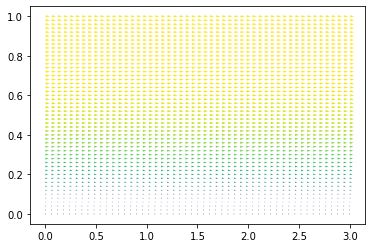

In [7]:
quiver(uR)

In [8]:
# Boundary conditions
bcs = [DirichletBC(W.sub(0).sub(0), Constant(0.), 1),
       DirichletBC(W.sub(0), Constant((0., 0.)), 3),
       DirichletBC(W.sub(0), uR, 2)]

## 1. Linear problem: $\tau = \frac{1}{2}\left(\nabla u + \nabla u^{T}\right)$

In [9]:
nu = firedrake.FacetNormal(mesh)

tauL = sym(grad(u))
F = div(w)*p*dx - inner(grad(w), tauL)*dx - inner(f, w)*dx
F += - phi*div(u)*dx
F += inner(dot(tauL, nu), w) * ds(2) + inner(dot(tauL, nu), w) * ds(3)
F += inner(dot(diag(tauL), nu), w) * ds(1)

In [10]:
solver_params = {
        "ksp_type": "preonly", 
        "pc_type": "lu", 
        "mat_type": "aij",
        "pc_factor_mat_solver_type": "mumps"}

In [11]:
solve(F==0, sol, bcs=bcs, solver_parameters=solver_params)
uL, pL = sol.split()

In [12]:
print("\n Norm uL: ", assemble(inner(uL, uL)*dx))
print("\n Norm tauL: ", assemble(inner(tauL, tauL)*dx))


 Norm uL:  3.4854256055405743

 Norm tauL:  8.227284393606496


#### Plots

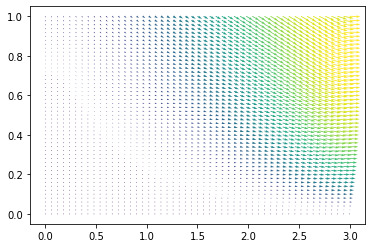

In [13]:
quiver(uL)

## 2. Glen's flow law: $\tau\left|\tau\right|^{ng-1} = \frac{1}{2}\left(\nabla u + \nabla u^{T}\right) $

In [14]:
from sympy.matrices import Matrix

#### PointsolveOperator

In [15]:
# Glen's flow law with exponent ng
ps = point_solve(lambda sol, y: Matrix(sol)*(Matrix(sol).norm()+1e-3)**(ng-1) - y,
                 function_space=V3,
                solver_params={'maxiter':50,
                               'x0':sym(grad(uR))})

In [16]:
tau = ps(sym(grad(u)))

F = div(w)*p*dx - inner(grad(w), tau)*dx - inner(f, w)*dx
F += - phi*div(u)*dx
F += inner(dot(tau, nu), w) * ds(2) + inner(dot(tau, nu), w) * ds(3)
F += inner(dot(diag(tau), nu), w) * ds(1)

In [17]:
solver_params = {
        "ksp_type": "preonly", 
        "pc_type": "lu", 
        "mat_type": "aij",
        "pc_factor_mat_solver_type": "mumps"}

solve(F==0, sol, bcs=bcs, solver_parameters=solver_params)
u_out, p_out = sol.split()

In [18]:
print("\n Norm u_out: ", assemble(inner(u_out, u_out)*dx))
print("\n Norm tau: ", assemble(inner(tau, tau)*dx))


 Norm u_out:  2.9194978805642875

 Norm tau:  3.093197016444589


#### Plots

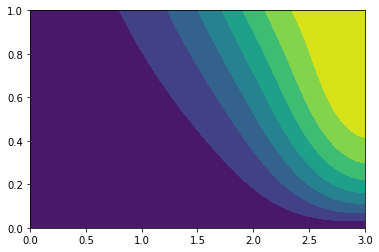

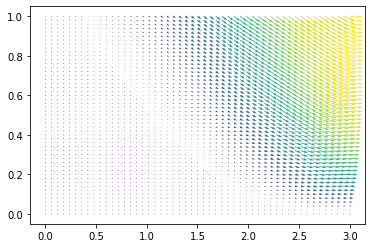

In [19]:
tricontourf(u_out)
quiver(u_out)

## 3. Compute isochrones shape

In [20]:
V4 = FunctionSpace(mesh, "CG", 2)
# Isochrones
alpha = Function(V4)
alphaL = Function(V4)
beta = TestFunction(V4)

bcs = [DirichletBC(V4, Constant(0.), 4)]
h = Constant(1.)

F = inner(dot(u_out, grad(alpha)), beta)*dx - h*beta*dx
solve(F==0, alpha, bcs=bcs, solver_parameters={ 'ksp_type': 'preonly', 'pc_type': 'lu'})

#### Plots

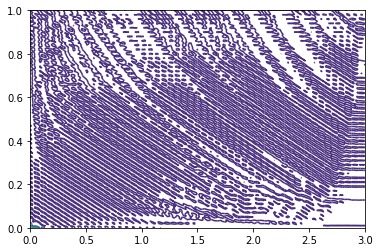

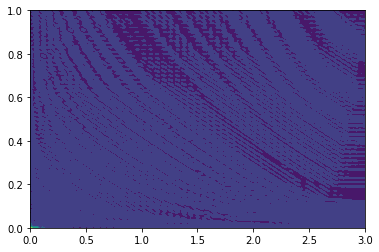

In [21]:
tricontour(alpha)
tricontourf(alpha)

## Optimization of the fluidity parameter

In [22]:
from firedrake_adjoint import *

In [23]:
# Geometry
mesh = RectangleMesh(3, 3, Lx, Ly)
x, y = SpatialCoordinate(mesh)

# Function spaces
V1 = VectorFunctionSpace(mesh, "CG", 2) # velocity
V2 = FunctionSpace(mesh, "CG", 1) # pressure
V3 = TensorFunctionSpace(mesh, "DG", 2) # stress tensor
W = MixedFunctionSpace((V1, V2))

# Functions
w, phi = TestFunctions(W)
sol = Function(W)
u, p = split(sol)
f = Function(V1).interpolate(as_vector([0, -rho*g]))

# Boundary conditions
uR = Function(V1)
r = (Ly - y)/Ly
uR.interpolate(as_vector([uS*(1 - r**(ng + 1)),
                          vS*(1 - r*(((ng+2)/(ng+1))-(1/(ng+1))*r**(ng + 1)))]))

# Boundary conditions
bcs = [DirichletBC(W.sub(0).sub(0), Constant(0.), 1),
       DirichletBC(W.sub(0), Constant((0., 0.)), 3),
       DirichletBC(W.sub(0), uR, 2)]

In [24]:
# Glen's flow law with exponent ng
ps = point_solve(lambda sol, y, A: Matrix(sol) - y,
                 function_space=V3,
                solver_params={'maxiter':50,
                               'x0':sym(grad(uR))})

In [25]:
solver_params = {
        "ksp_type": "preonly", 
        "pc_type": "lu", 
        "mat_type": "aij",
        "pc_factor_mat_solver_type": "mumps"}

In [26]:
A = Constant(1)
tau = ps(sym(grad(u)), A)

def J(A):
    tau = ps(sym(grad(u)), A)
    F = div(w)*p*dx - inner(grad(w), tau)*dx - inner(f, w)*dx
    F += - phi*div(u)*dx
    F += inner(dot(tau, nu), w) * ds(2) + inner(dot(tau, nu), w) * ds(3)
    F += inner(dot(diag(tau), nu), w) * ds(1)
    solve(F==0, sol, bcs=bcs, solver_parameters=solver_params)
    u_out, p_out = sol.split()
    return assemble(u2_out**2)*dx